## Progetto Finale di introduzione alla DataScience
con questo notebook ci poniamo l'obiettivo di
* capire quale sia la categoria di applicazioni avente il massimo rapporto tra numero di recensioni e numero di download (che, da adesso, per brevità, chiameremo nr/nd)

* capire, dentro a questa categoria, se sono più le app a pagamento o quelle free ad avere un nr/nd più alto

* investigare l'esistenza di una eventuale correlazione tra il nr/nd e il rating di una applicazione: se questa metrica cresce, generalmente, il rating aumenterà? Diminuirà? Nessuna delle due? Lo scopriremo

Le ipotesi formulate sono quindi le seguenti:
1. immaginiamo che la categoria di applicazioni avente il massimo rapporto tra numero di recensioni e numero di download siano le app di categoria PRODUCTIVITY
2. immaginiamo che, all'interno della categoria trovata, generalmente, le app a pagamento avranno un nr/nd più alto rispetto a quelle free
3. immaginiamo che, al crescere del rapporto nr/nd diminuisca il rating (perché pensiamo che, di solito, se la maggior parte degli utilizzatori lascia una recensione, è per criticare qualcosa piuttosto che per esprimere soddisfazione)


trovare la categoria di app che "eccelle" più delle altre in questa metrica potrebbe aiutare, ad esempio, una software house che vuole sviluppare applicazioni particolarmente innovative o che per qualche motivo hanno bisogno di tanti feedback anche dopo varie release: conoscendo i risultati di questa analisi, saprà su quale categoria puntare, avendo trovato la user-base più "attiva" possibile.

In [1]:
## importiamo il necessario:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import scipy.stats as stats
import sklearn
#importiamo il dataset e visualizziamo prime 5 righe:
playstore = pd.read_csv('googleplaystore.csv')
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [2]:
#visualizziamo numero di righe e colonne:
print("Numero Righe, Numero Colonne",playstore.shape)

Numero Righe, Numero Colonne (10841, 13)


In [3]:
#visualizziamo le informazioni del dataset:
playstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [4]:
#visualizziamo eventuali valori nulli:
playstore.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [5]:
#eliminiamo le righe con valori nulli nella colonna 'Rating':
playstore = playstore.dropna(axis=0, subset=['Rating'])
playstore.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    1
Genres            0
Last Updated      0
Current Ver       4
Android Ver       3
dtype: int64

Come vediamo ci sono ben 1474 righe che hanno valore nullo sulla colonna Rating, potremmo pensare di
* rimuovere tutte queste righe (e quindi ridurre significativamente la dimensione del nostro dataset)
* "completare" i valori nulli usando il valore medio del rating.
Optiamo per la prima opzione, in quanto la seconda potrebbe portare ad una distorsione dei dati per quanto riguarda l'analisi che ci proponiamo di attuare, infatti, se pensiamo di voler cercare una correlazione tra nr/nd e Rating e usiamo il valore medio in tutte le righe che presentano attualmente un valore nullo, avremo dei risultati irrealistici in tutte queste righe,
## esempio:
il rating medio è 2.3, quindi in 1474 avremo il valore 2.3 sulla colonna Rating, ciò significa che poi, quando andremo a cercare la correlazione, potremmo avere:
App 1: rating = 2.3, nr/nd = 40%
App 2: rating = 2.3, nr/nd = 60%
App 3: rating = 2.3, nr/nd = 99%
e la nostra analisi è stata inquinata, quando magari, rimuovendo le entrate in cui Rating è nullo avremmo trovato una correlazione

Analizzando il dataset individuiamo le caratteristiche che, a nostro parere, dovrebbero essere quantitative:
* Rating 
* Reviews
* Installs
* Size
* Price


In [6]:
playstore.describe() #visualizziamo statistiche del dataset

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


Notiamo che utilizzando il metodo describe abbiamo informazioni solo sulla colonna Rating, come mai le altre (anche se pensiamo essere quantitative) non vengono mostrate?
Perché contengono valori come stringhe.
Inoltre notiamo qualcosa di "curioso" rispetto al valore massimo della colonna Rating, se i rating sul playstore vanno da 1 a 5 stelle, come è possibile che il valore massimo sia 19? C'è una riga problematica nel nostro dataset, che decidiamo di eliminare, in quanto, probabilmente a causa di un errore nel processo di raccolta dei dati, risulta "disallineata", ovvero i valori sono spostati di una colonna:

In [7]:
righe_rumorose = playstore[(playstore['Rating']>5) | (playstore['Rating']<1)]
print("Numero di righe problematiche rispetto al rating: ",righe_rumorose.shape[0]) # controlliamo quante sono, e scopriamo che c'è una sola riga di questo tipo
(righe_rumorose.head(1)) # quindi la visualizziamo con head

Numero di righe problematiche rispetto al rating:  1


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


i valori risultano chiaramente spostati di una colonna (dovrebbe essere Rating = 1.9, Reviews=19, Size = 3.0M, eccetera), ma se volessimo "sistemare" questa colonna ci troveremmo con un valore nullo dentro alla colonna Category, il che non ci fa comodo perché vogliamo fare l'analisi proprio su questa colonna. Quindi decidiamo di eliminare interamente la riga.

In [8]:
(playstore.describe()) # prima di eliminarla, visualizziamo le statistiche del dataset


,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [9]:
playstore = playstore.drop(righe_rumorose.index, axis=0) # eliminiamo la riga rumorosa
playstore.describe() # visualizziamo le statistiche del dataset dopo aver eliminato la riga rumorosa

,Rating
count,9366.000000
mean,4.191757
std,0.515219
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


**Pulizia dei valori duplicati (se sono presenti)**

In [10]:
#visualizziamo il numero di valori duplicati quindi con lo stesso valore sotto la colonna app:
print("Numero di valori duplicati: ",playstore.duplicated(subset=['App']).sum())
#eliminiamo i valori duplicati:
playstore = playstore.drop_duplicates(subset=['App'])
#verifichiamo che non ci siano più valori duplicati:
print("Numero di valori duplicati: ",playstore.duplicated(subset=['App']).sum())

Numero di valori duplicati:  1170
Numero di valori duplicati:  0


torniamo sulle variabili Install, Reviews, Price e Size, che dovrebbero risultare quantitative ma non accade. Prima di tutto guardiamo il tipo

In [11]:
print("Tipo di Installs:\t" + str(type(playstore['Installs'][0])))
print("Tipo di Reviews:\t" + str(type(playstore['Reviews'][0])))
print("Tipo di Price:\t\t" + str(type(playstore['Price'][0])))
print("Tipo di Size:\t\t" + str(type(playstore['Size'][0])))

Tipo di Installs:	<class 'str'>
Tipo di Reviews:	<class 'str'>
Tipo di Price:		<class 'str'>
Tipo di Size:		<class 'str'>


Notiamo che sono appunto tutte stringhe.
Le uniche colonne che però ci interessa realmente pulire e "rendere quantitative" sono: Installs e Reviews, in quanto Price e Size non giocano alcun ruolo nella nostra analisi.

## Trasformiamo Installs
Installs contiene valore in formato stringa perché il numero di download è espresso nella forma n+, per indicare che è stata scaricata "più di n volte"

In [12]:
if(type(playstore['Installs'][0]) is str):
    playstore['Installs'] = [int(x.replace('+','').replace(',','')) for x in playstore['Installs']]
# ri-controlliamo le statistiche:
playstore.describe()

,Rating,Installs
count,8196.000000,8.196000e+03
mean,4.173243,9.165090e+06
std,0.536625,5.825087e+07
min,1.000000,1.000000e+00
25%,4.000000,1.000000e+04
50%,4.300000,1.000000e+05
75%,4.500000,1.000000e+06
max,5.000000,1.000000e+09


## Trasformiamo Reviews
Reviews contiene valore in formato stringa, lo trasformiamo in numero usando astype(int)

In [13]:
if(type(playstore['Reviews'][0]) is str):
    playstore['Reviews'] = playstore['Reviews'].astype(int)
# ri-controlliamo le statistiche:
playstore.describe()

,Rating,Reviews,Installs
count,8196.000000,8.196000e+03,8.196000e+03
mean,4.173243,2.552515e+05,9.165090e+06
std,0.536625,1.985594e+06,5.825087e+07
min,1.000000,1.000000e+00,1.000000e+00
25%,4.000000,1.260000e+02,1.000000e+04
50%,4.300000,3.004000e+03,1.000000e+05
75%,4.500000,4.381300e+04,1.000000e+06
max,5.000000,7.815831e+07,1.000000e+09


## Drop di colonne che non utilizzeremo
per completare la pulizia, infine, eliminiamo dal dataset le colonne che non utilizziamo perché sono di nulla utilità rispetto al nostro obiettivo

In [14]:
playstore.drop(columns=['Price', 'Size', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], inplace=True)
playstore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8196 entries, 0 to 10840
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   App       8196 non-null   object 
 1   Category  8196 non-null   object 
 2   Rating    8196 non-null   float64
 3   Reviews   8196 non-null   int32  
 4   Installs  8196 non-null   int64  
 5   Type      8196 non-null   object 
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 674.2+ KB


# Considerazione sul numero di download:
Ha senso, ai fini della nostra analisi, considerare applicazioni con un numero relativamente basso di installazioni?
Immaginiamo lo sviluppatore 'indie' che fa scaricare e recensire la sua app appena sviluppata a tutta la sua famiglia, che possiamo immaginare di 5 componenti, quando andremo a calcolare il nostro rapporto nr/nd avremo 100%, ma è davvero significativo?
Risulta essere un indicatore realmente affidabile su un così basso numero di utenti?
Per questo motivo decidiamo di non considerare le applicazioni con meno di 500 Installs

In [15]:
# togliamo tutte le applicazioni con meno di 500 installs:
playstore = playstore[playstore['Installs'] >= 500]
playstore.describe()

,Rating,Reviews,Installs
count,7756.000000,7.756000e+03,7.756000e+03
mean,4.159180,2.697316e+05,9.685023e+06
std,0.506758,2.040189e+06,5.983851e+07
min,1.000000,1.000000e+00,5.000000e+02
25%,4.000000,2.070000e+02,1.000000e+04
50%,4.300000,4.093000e+03,5.000000e+05
75%,4.500000,5.035950e+04,5.000000e+06
max,5.000000,7.815831e+07,1.000000e+09


In [16]:
# calcoliamo il rapporto tra numero di recensioni e numero di installazioni:
playstore['nr/nd'] = playstore['Reviews'] / playstore['Installs'] * 100
playstore.describe()
# ordiniamo il dataset in base al rapporto tra numero di recensioni e numero di installazioni:
playstore = playstore.sort_values(by='nr/nd', ascending=False)
playstore.head(10)

,App,Category,Rating,Reviews,Installs,Type,nr/nd
4663,Alarmy (Sleep If U Can) - Pro,LIFESTYLE,4.8,10249,10000,Paid,102.490
6056,Be Stronger,HEALTH_AND_FITNESS,4.8,787,1000,Paid,78.700
7037,BZ Reminder PRO,BUSINESS,4.8,726,1000,Paid,72.600
7165,My Movies Pro - Movie & TV Collection Library,LIFESTYLE,4.6,6477,10000,Paid,64.770
9304,Carrier Landings Pro,FAMILY,4.6,5969,10000,Paid,59.690
4702,V Bucks ProTips New,SOCIAL,4.7,594,1000,Free,59.400
9627,ai.type keyboard Plus + Emoji,TOOLS,4.5,57076,100000,Paid,57.076
4946,Flud (Ad free),VIDEO_PLAYERS,4.8,5639,10000,Paid,56.390
6618,bpresso PRO,MEDICAL,4.4,515,1000,Paid,51.500
4556,Day R Premium,FAMILY,4.8,51068,100000,Paid,51.068


## Problema di precisione nei dati
Notiamo valori sospetti dopo aver calcolato nr/nd ed aver ordinato le righe del dataframe in base a questa metrica (ad esempio un rapporto del 400% dovuto al fatto che ci fossero 4 reviews per una applicazione installata da un solo utente, o 20 per 10 utenti, eccetera... ) questo ci ha portato a ulteriori controlli sui dati.
Siamo ritornati a pulire i dati, in quanto non è possibile che, per una certa applicazione, ci siano più reviews che installazioni.
Ma perché accade questo? Con tutta probabilità, ciò è causato dal fatto che il numero di installazioni non è un numero preciso, bensì un range (infatti come abbiamo detto in precedenza, era indicato nella forma del tipo n+), questo significa che, se una applicazione ha "1+ downloads" significa che ha un numero di downloads maggiore o uguale a 1 e però minore di 5, se una applicazione ha un numero di downloads listato come 1,000+ significa che ha tra le 1,000 e  le 5,000 installazioni, e così via.
Mentre, il numero di reviews è un numero preciso.
Per cercare di arginare questo problema procediamo eliminando dal dataset le righe in cui il nr/nd è superiore a 100


In [17]:
# eliminiamo dal dataset le righe in cui nr/nd è maggiore di 100:
playstore = playstore[playstore['nr/nd'] <= 100]

[[[3.700e+01 0.000e+00 0.000e+00]
  [1.431e+03 4.300e+01 7.000e+00]]

 [[8.000e+00 0.000e+00 0.000e+00]
  [8.340e+02 3.600e+01 6.000e+00]]

 [[4.300e+01 0.000e+00 0.000e+00]
  [6.310e+02 1.100e+01 1.000e+00]]

 [[2.000e+01 0.000e+00 0.000e+00]
  [2.640e+02 7.000e+00 0.000e+00]]

 [[1.000e+01 0.000e+00 0.000e+00]
  [2.650e+02 6.000e+00 0.000e+00]]

 [[2.200e+01 0.000e+00 0.000e+00]
  [2.490e+02 3.000e+00 2.000e+00]]

 [[0.000e+00 0.000e+00 0.000e+00]
  [2.590e+02 8.000e+00 1.000e+00]]

 [[1.000e+01 0.000e+00 0.000e+00]
  [2.430e+02 1.000e+00 0.000e+00]]

 [[1.300e+01 0.000e+00 0.000e+00]
  [2.310e+02 6.000e+00 2.000e+00]]

 [[4.000e+00 0.000e+00 0.000e+00]
  [2.360e+02 8.000e+00 0.000e+00]]]


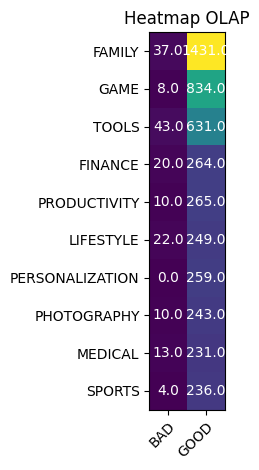

In [18]:
# Recuperiamo le diverse categorie per la rappresentazione OLAP ma solo le prime 10 con valori più alti di nr/nd
quantize_category = playstore['Category'].value_counts().index[:10].tolist()
quantize_rating = ['BAD', 'GOOD']
quatize_nr_nd = ['LOW', 'MEDIUM', 'HIGH']
OLAP = np.zeros((len(quantize_category), len(quantize_rating), len(quatize_nr_nd)))

playstore.loc[playstore['Rating'].between(1, 3), 'Rating_quant'] = quantize_rating[0]
playstore.loc[playstore['Rating'].between(3, 5), 'Rating_quant'] = quantize_rating[1]
playstore.loc[playstore['nr/nd'].between(0, 15), 'nr/nd_quant'] = quatize_nr_nd[0]
playstore.loc[playstore['nr/nd'].between(15, 35), 'nr/nd_quant'] = quatize_nr_nd[1]
playstore.loc[playstore['nr/nd'].between(35, 100), 'nr/nd_quant'] = quatize_nr_nd[2]
for i in range(len(quantize_category)):
    for j in range(len(quantize_rating)):
        for k in range(len(quatize_nr_nd)):
            OLAP[i][j][k] = playstore[(playstore['Category'] == quantize_category[i]) & 
                                       (playstore['Rating_quant'] == quantize_rating[j]) & 
                                       (playstore['nr/nd_quant'] == quatize_nr_nd[k])].shape[0]
print(OLAP)

#Facciamo una heatmap per visualizzare meglio i dati:
fig, ax = plt.subplots()
im = ax.imshow(OLAP[:, :, 0])
ax.set_xticks(np.arange(len(quantize_rating)))
ax.set_yticks(np.arange(len(quantize_category)))
ax.set_xticklabels(quantize_rating)
ax.set_yticklabels(quantize_category)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(quantize_category)):
    for j in range(len(quantize_rating)):
        text = ax.text(j, i, OLAP[i][j][0], ha="center", va="center", color="w")
ax.set_title("Heatmap OLAP")
fig.tight_layout()
plt.show()




